In [8]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "PH_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

# Load Files

In [2]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_PH_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
len(windmill)

2

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [5]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [6]:
df = features.parallelize_extract(df)

parallelize_extract time:  88.05948686599731


In [7]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [8]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [9]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [10]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [11]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [12]:
len(df_train)

17474

In [13]:
df_train.to_parquet(constant.PH_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.PH_SC_EVL_path, index=False)

# Neural Network Train

In [9]:
df_train = pd.read_parquet(constant.SL_SC_TRAIN_path)

In [56]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=40
hidden_size = 200
output_size = 1

## Original Features


In [57]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [58]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

In [59]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [61]:
class MLP_Regression(nn.Module):

  def __init__(self, input_size, hidden_size, bias=0):
    super(MLP_Regression, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc1.bias.data.fill_(bias)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, 1)
    self.d = nn.Dropout(p=0.5)

  def forward(self, x):
    x = F.sigmoid(self.fc1(x))
    x = F.sigmoid(self.fc2(x))
    x = self.fc3(x)

    return x

In [62]:
def train_model(
    model, 
    lr,
    num_epochs,
    X_train, 
    y_train
    ):
    loss_fn = torch.nn.SmoothL1Loss()

    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = num_epochs

    train_hist = np.zeros(num_epochs)
    y_pred = None
    for t in range(num_epochs):
 
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)

        if t % 10 == 0 or t == num_epochs-1:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    return model.eval(), train_hist, y_pred

In [63]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [64]:
model_original, train_hist_original, y = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor)

                                            # path=model_path+"original_model.pth")

Epoch 0 train loss: 0.03800364211201668
Epoch 10 train loss: 0.028239086270332336
Epoch 20 train loss: 0.025585312396287918
Epoch 30 train loss: 0.02458512969315052
Epoch 39 train loss: 0.024315716698765755


In [65]:
y

tensor([[0.1576],
        [0.1559],
        [0.1556],
        ...,
        [0.1628],
        [0.1614],
        [0.1618]], grad_fn=<AddmmBackward>)

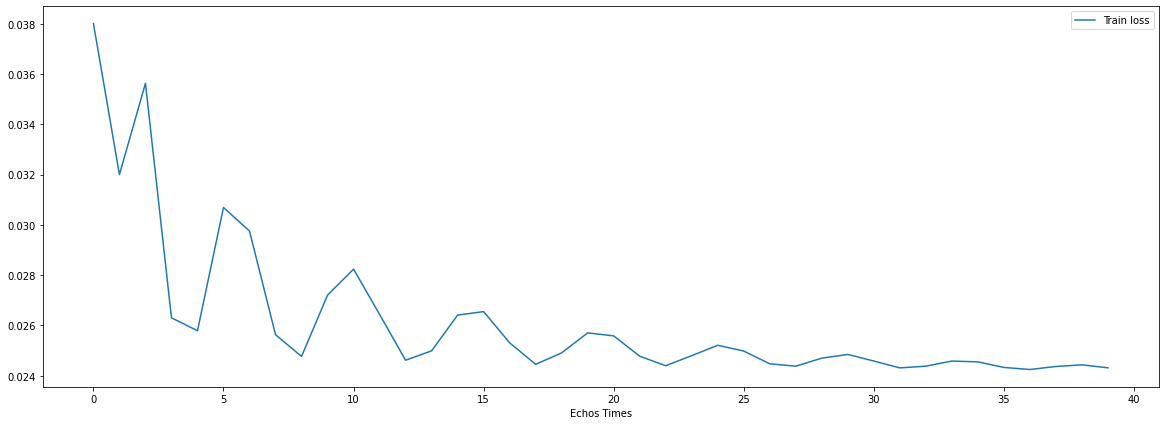

In [66]:
myplot.model_loss({"Train loss":train_hist_original})
# myplot.model_loss({"Train loss":train_hist_original}, path=plot_pat/
# h+"original_loss.png")

## Windshear Features

In [67]:
model_wsr = MLP_Regression(
  input_size=44,
  hidden_size=hidden_size
)

In [23]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

In [24]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [68]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [69]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor)

Epoch 0 train loss: 0.14731517434120178
Epoch 10 train loss: 0.03809239715337753
Epoch 20 train loss: 0.03150118514895439
Epoch 30 train loss: 0.024405578151345253
Epoch 39 train loss: 0.02453557960689068


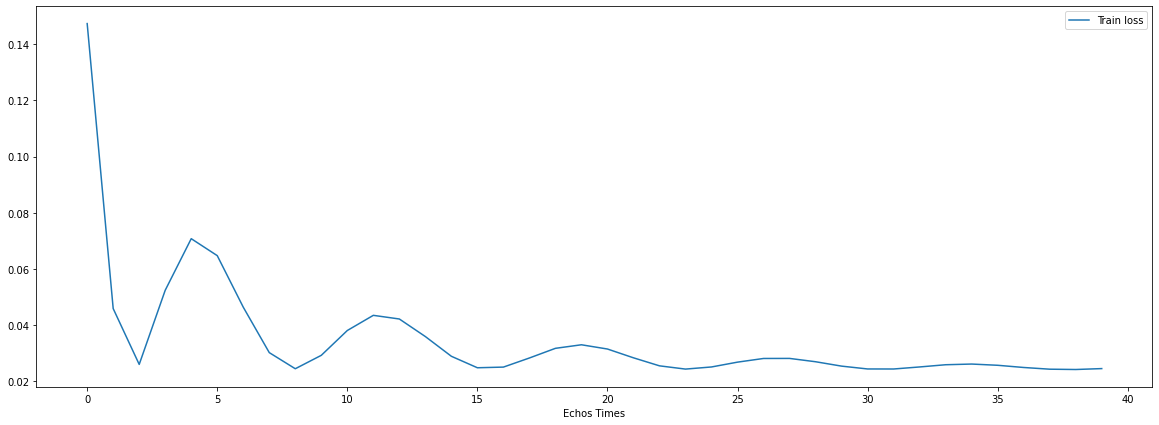

In [70]:
myplot.model_loss({"Train loss":train_hist_wsr})

## Geo Features

In [28]:
model_geo = MLP_Regression(
  input_size=46,
  hidden_size=hidden_size
)

In [29]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

In [30]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [31]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [32]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.03895412012934685
Epoch 10 train loss: 0.02023645117878914
Epoch 20 train loss: 0.01550415437668562
Epoch 30 train loss: 0.01191876083612442
Epoch 40 train loss: 0.0098493080586195


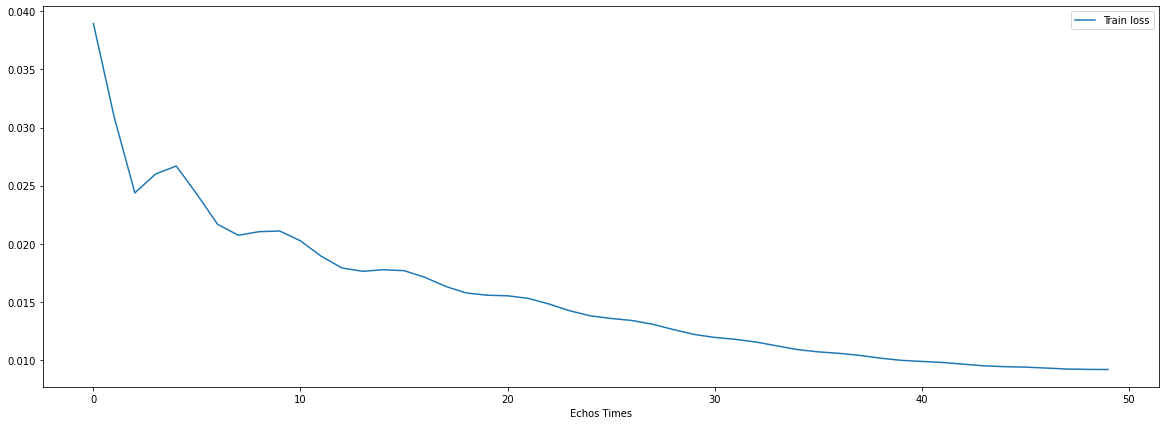

In [33]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [34]:
model_semigeo = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [35]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

In [36]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [37]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [38]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.039205778390169144
Epoch 10 train loss: 0.019428474828600883
Epoch 20 train loss: 0.01544807106256485
Epoch 30 train loss: 0.011697672307491302
Epoch 40 train loss: 0.009490733034908772


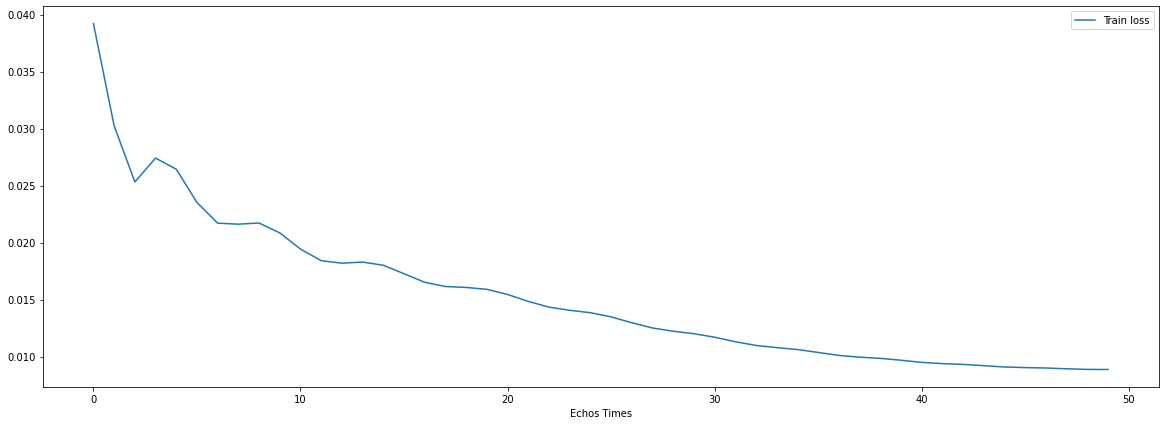

In [39]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")